In [113]:
%load_ext autoreload
%autoreload 2

from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
import os
import sys

# Set the root directory to BPX Challenge Home path
os.chdir("../")

from scripts.env import *
from scripts.utils import load_hp_params, date_parser
from scripts.plots import Parallel_Coordinates

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Plot some of the good predictions

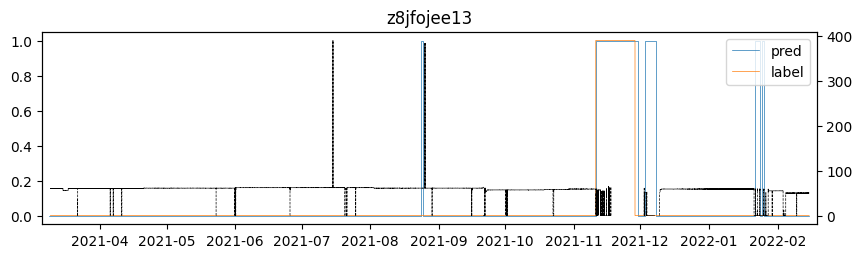

In [146]:
pred_folders = sorted(glob(f"{PRED_FOL}_{SLIDE_N}/*.csv"))
file = np.random.choice(pred_folders)
good_wells = ['z8jfojee13', 'z8jfojeox8', 'z8jfojf31j', 'z8jfojf37f', 'z8jfojf37z',
                'z8jfojfoxx', 'z8jfojjfjx', 'z8jfojo31x', 'z8jfojo3j7', 'z8jfojo3j8', 
                'z8jfojo71z', 'z8jfojo7jf', 'z8jfojo88j', 'z8jfojoe13', 'z8jfojoefx', 
                'z8jfojojf8', 'z8jfojoxzx']


for _a in good_wells[:1]:
    file = f"{PRED_FOL}_{SLIDE_N}/pred_{_a}.csv"
    API = file.split("/")[-1].replace(".csv","").split("_")[1]
    label_folder = sorted(glob(f"{ESP_OUTPUT_FOLDER}_{SLIDE_N}/{API}/*.parquet"))
    label_df = pd.concat([pd.read_parquet(file) for file in label_folder])
    label_df.sort_index()


    df = pd.read_csv(file)
    df["Date"] = pd.to_datetime(df["Date"])
    fig,ax = plt.subplots(figsize=(10,2.5))
    ax.step(df.Date, df.Fail, lw=0.5, label="pred")
    ax.step(label_df.index, label_df.Label, lw=0.5, label="label")
    ax.legend(loc="upper right")
    ax.set_title(df.API[0])
    ax.margins(x=0.01)
    bx = ax.twinx()
    bx.plot(label_df.index, label_df.motor_frequency, c="k", lw=0.5, ls="--")
    # bx.plot(label_df.index, label_df.output_amps_phase_b, c="k", lw=0.5, ls="--")
    # bx.set_ylim(0,10)
    plt.show()

### Plot the confusion matrix

In [3]:

os.system("python scripts/evaluate.py")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/josesmac/Documents/Competitions/BPX_Challenge/JTK-Challenge/jtk/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.914893627166748
       test_fbeta           0.9126814603805542
        test_loss           0.27013880014419556
──────────────────────────────��─────────────────────────────────────────────────────────────────────────────────────────
──────────────────
Confusion Matrix
──────────────────
[[215  20]
 [ 20 215]]
──────────────────


0

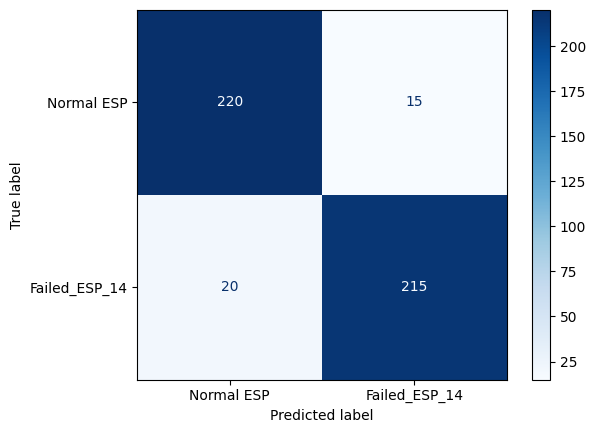

In [6]:
cm = np.array([[220,  15],[20, 215]])
cls_labels = np.array(["Normal ESP",f"Failed_ESP_{SLIDE_N}"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_labels)
disp.plot(cmap="Blues")
plt.savefig("images/confusion_matrix.png", dpi=200, facecolor='w', edgecolor='none',bbox_inches='tight')
plt.show()

### Plot the hyperparameter search space

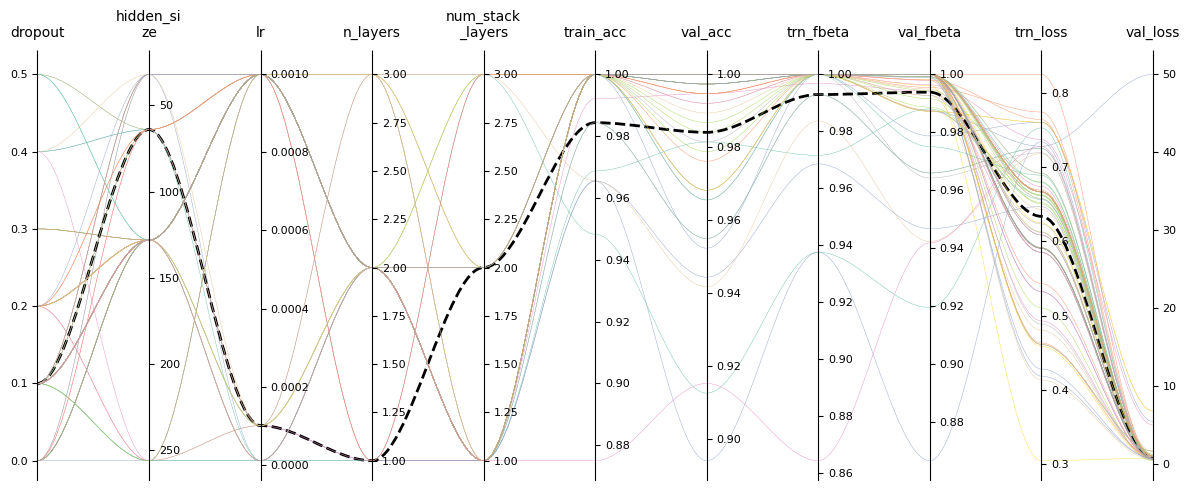

In [5]:
hpp_df = load_hp_params("lightning_logs/JTK_Challenge/version_*")

fig,ax = plt.subplots(figsize=(12,5))
pcd = Parallel_Coordinates(hpp_df,ax).plot()
plt.tight_layout()
plt.savefig("images/hyperparams.png", dpi=200, facecolor='w', edgecolor='none',bbox_inches='tight')
plt.show()

### Plot Raw Data

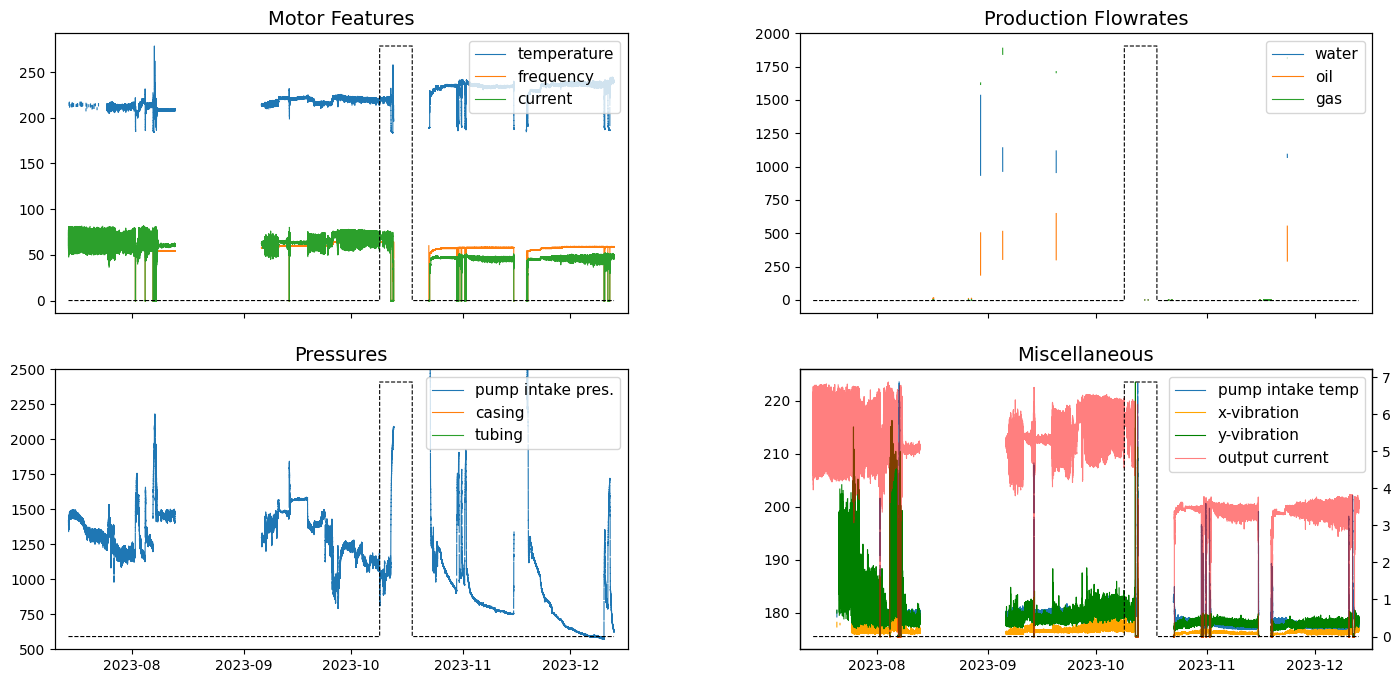

In [82]:
API = "z8j7xj31j7"
label_folder = sorted(glob(f"{ESP_OUTPUT_FOLDER}_{SLIDE_N}/{API}/*.parquet"))
ldf = pd.concat([pd.read_parquet(file) for file in label_folder])
ldf.sort_index()


fig,ax = plt.subplots(2,2,figsize=(17,8), gridspec_kw={"hspace":0.2,"wspace":0.3}, sharex=True)
fs, lw = 14, 0.8
ax = ax.flatten()

ax[0].set_title("Motor Features", fontsize=fs)
ax[0].plot(ldf.index, ldf.motor_temp, lw=lw, label="temperature")
ax[0].plot(ldf.index, ldf.motor_frequency, lw=lw, label="frequency")
ax[0].plot(ldf.index, ldf.motor_amps_phase_b, lw=lw, label="current")
a = ax[0].twinx()
a.step(ldf.index, ldf.Label, lw=lw, ls="--", c="k")
ax[0].margins(x=0.025), ax[0].legend(loc="upper right", fontsize=fs-3)
a.set_yticks([])

ax[1].set_title("Production Flowrates", fontsize=fs)
ax[1].plot(ldf.index, ldf.water_rate, lw=lw, label="water")
ax[1].plot(ldf.index, ldf.oil_rate, lw=lw, label="oil")
ax[1].plot(ldf.index, ldf.gas_rate, lw=lw, label="gas")
ax[1].margins(x=0.025), ax[1].set_ylim(-100,2000), ax[1].legend(loc="upper right", fontsize=fs-3)
a = ax[1].twinx()
a.step(ldf.index, ldf.Label, lw=lw, ls="--", c="k")
a.set_yticks([])

ax[2].set_title("Pressures", fontsize=fs)
ax[2].plot(ldf.index, ldf.pump_intake_pressure, lw=lw, label="pump intake pres.")
ax[2].plot(ldf.index, ldf.casing_pressure, lw=lw, label="casing")
ax[2].plot(ldf.index, ldf.tubing_pressure, lw=lw, label="tubing")
ax[2].set_ylim(500,2500), ax[2].legend(loc="upper right", fontsize=fs-3)
a = ax[2].twinx()
a.step(ldf.index, ldf.Label, lw=lw, ls="--", c="k")
a.set_yticks([])

ax[3].set_title("Miscellaneous", fontsize=fs)
ax[3].plot(ldf.index, ldf.pump_intake_temp, lw=lw, label="pump intake temp")
b = ax[3].twinx()
b.plot(ldf.index, ldf.x_vibration, lw=lw, label="x-vibration", c="orange")
b.plot(ldf.index, ldf.y_vibration, lw=lw, label="y-vibration", c="g")
c = b.twinx()
c.plot(ldf.index, ldf.output_amps_phase_b, lw=lw, label="output current", c="r", alpha=0.5)
c.set_yticks([])
b.yaxis.set_ticks_position("right")
legend_handles = []
legend_labels = []
for axx in [ax[3],b,c]:
    for h, l in zip(*axx.get_legend_handles_labels()):
        legend_handles.append(h)
        legend_labels.append(l)

ax[3].legend(legend_handles, legend_labels, loc="upper right", fontsize=fs-3)
a = ax[3].twinx()
a.step(ldf.index, ldf.Label, lw=lw, ls="--", c="k")
a.set_yticks([])

plt.savefig("images/input_data.png", dpi=200, facecolor="w", edgecolor="none",bbox_inches="tight")
plt.show()

### Stretch Goal

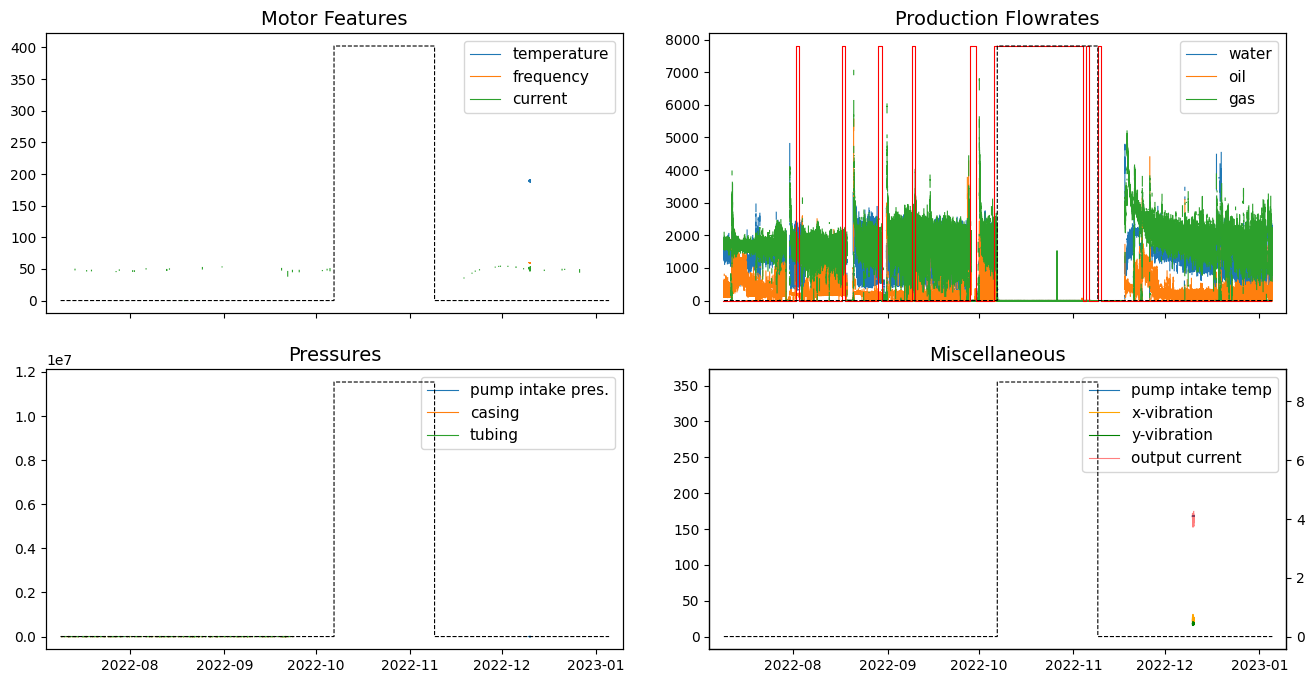

In [84]:
API = "z8jfojo71z" #"z8jfojojf8", "z8jfojoxzx"
label_folder = sorted(glob(f"{ESP_OUTPUT_FOLDER}_{SLIDE_N}/{API}/*.parquet"))
ldf = pd.concat([pd.read_parquet(file) for file in label_folder])
ldf.sort_index()

# prediction
file = f"{PRED_FOL}_{SLIDE_N}/pred_{API}.csv"
pred = pd.read_csv(file)
pred["Date"] = pd.to_datetime(pred["Date"])


fig,ax = plt.subplots(2,2,figsize=(16,8), gridspec_kw={"hspace":0.2,"wspace":0.15}, sharex=True)
fs, lw = 14, 0.8
ax = ax.flatten()


ax[0].set_title("Motor Features", fontsize=fs)
ax[0].plot(ldf.index, ldf.motor_temp, lw=lw, label="temperature")
ax[0].plot(ldf.index, ldf.motor_frequency, lw=lw, label="frequency")
ax[0].plot(ldf.index, ldf.motor_amps_phase_b, lw=lw, label="current")
a = ax[0].twinx()
a.step(ldf.index, ldf.Label, lw=lw, ls="--", c="k")
ax[0].margins(x=0.025), ax[0].legend(loc="upper right", fontsize=fs-3)
a.set_yticks([])

ax[1].set_title("Production Flowrates", fontsize=fs)
ax[1].plot(ldf.index, ldf.water_rate, lw=lw, label="water")
ax[1].plot(ldf.index, ldf.oil_rate, lw=lw, label="oil")
ax[1].plot(ldf.index, ldf.gas_rate, lw=lw, label="gas")
ax[1].legend(loc="upper right", fontsize=fs-3)
a = ax[1].twinx()
a.step(pred.Date, pred.Fail, lw=lw, c="r")
a.step(ldf.index, ldf.Label, lw=lw, ls="--", c="k")
a.set_yticks([])

ax[2].set_title("Pressures", fontsize=fs)
ax[2].plot(ldf.index, ldf.pump_intake_pressure, lw=lw, label="pump intake pres.")
ax[2].plot(ldf.index, ldf.casing_pressure, lw=lw, label="casing")
ax[2].plot(ldf.index, ldf.tubing_pressure, lw=lw, label="tubing")
ax[2].legend(loc="upper right", fontsize=fs-3)
a = ax[2].twinx()
a.step(ldf.index, ldf.Label, lw=lw, ls="--", c="k")
a.set_yticks([])

ax[3].set_title("Miscellaneous", fontsize=fs)
ax[3].plot(ldf.index, ldf.pump_intake_temp, lw=lw, label="pump intake temp")
b = ax[3].twinx()
b.plot(ldf.index, ldf.x_vibration, lw=lw, label="x-vibration", c="orange")
b.plot(ldf.index, ldf.y_vibration, lw=lw, label="y-vibration", c="g")
c = b.twinx()
c.plot(ldf.index, ldf.output_amps_phase_b, lw=lw, label="output current", c="r", alpha=0.5)
c.set_yticks([])
b.yaxis.set_ticks_position("right")
legend_handles = []
legend_labels = []
for axx in [ax[3],b,c]:
    for h, l in zip(*axx.get_legend_handles_labels()):
        legend_handles.append(h)
        legend_labels.append(l)

ax[3].legend(legend_handles, legend_labels, loc="upper right", fontsize=fs-3)
a = ax[3].twinx()
a.step(ldf.index, ldf.Label, lw=lw, ls="--", c="k")
a.set_yticks([])

plt.savefig("images/stretch_goal.png", dpi=200, facecolor="w", edgecolor="none",bbox_inches="tight")
plt.show()

### Class imbalance

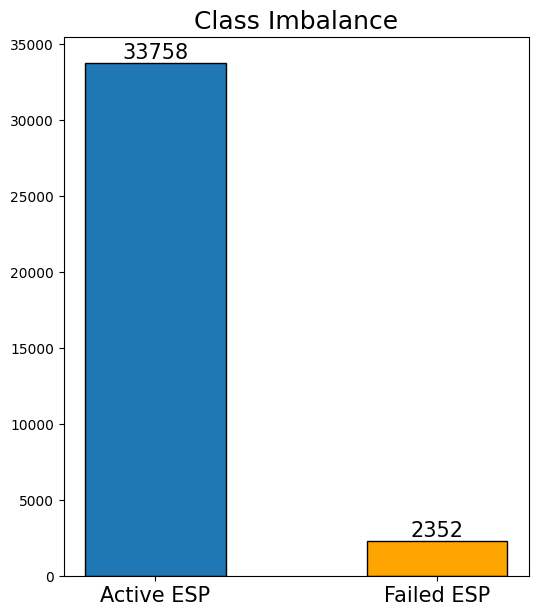

In [105]:
active_wells = len(glob(f"{DAILY_OUTPUT_FOLDER}_{SLIDE_N}/*_AC.npz"))
fail_esp_wells = len(glob(f"{DAILY_OUTPUT_FOLDER}_{SLIDE_N}/*_PF.npz"))


fig,ax = plt.subplots(figsize=(6,7))
fs=18
p = ax.bar(["Active ESP","Failed ESP"],[active_wells, fail_esp_wells],width=0.5,
           color=["C0","orange"],ec="k")
ax.bar_label(p, label_type='edge', fontsize=fs-3)
ax.set_title("Class Imbalance", fontsize=fs)
for item in ([ax.xaxis.label] + ax.get_xticklabels()):
    item.set_fontsize(fs-3)
plt.savefig("images/class_imbalance.png", dpi=200, facecolor="w", edgecolor="none",bbox_inches="tight")
plt.show()

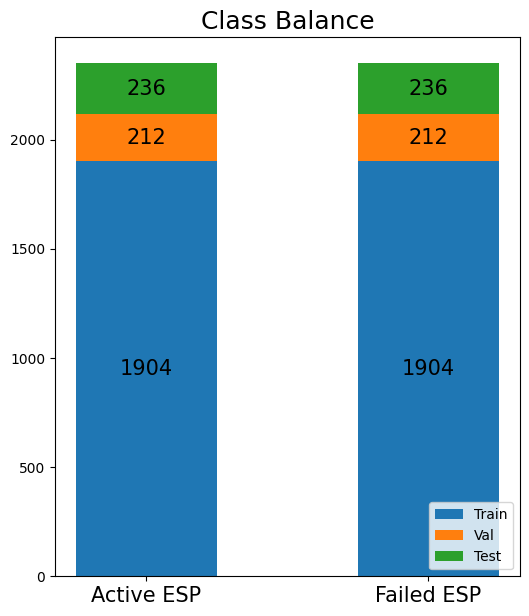

In [112]:
fig,ax = plt.subplots(figsize=(6,7))
fs=18

well_classes = ["Active ESP","Failed ESP"]

tr_ts_sp = {"Train":[1904, 1904], "Val":[212, 212], "Test":[236, 236]}

bottom = np.zeros(2)

for split, split_count in tr_ts_sp.items():
    p = ax.bar(well_classes, split_count, width=0.5, label=split, bottom=bottom)
    bottom += split_count
    ax.bar_label(p, label_type='center', fontsize=fs-3)
ax.legend(loc="lower right")

ax.set_title("Class Balance", fontsize=fs)
for item in ([ax.xaxis.label] + ax.get_xticklabels()):
    item.set_fontsize(fs-3)
plt.savefig("images/class_balance_tts.png", dpi=200, facecolor="w", edgecolor="none",bbox_inches="tight")
plt.show()

### View top ESP failure cause from tracker doc

In [127]:
esp_df = pd.read_excel(f"Train/esp_tracker_train.xlsx",
                       index_col=0, date_parser=date_parser,
                       parse_dates=["Ins Date","Startup Date","Pull date","Corrected Failure Date"])
esp_df.columns = [name.replace(" ","_") for name in esp_df.columns]
esp_df = esp_df.reset_index(drop=True)
esp_df["Fail_reason"] = esp_df["Fail_reason"].apply(lambda x: x.replace("Conditions", "Condition") if not pd.isnull(x) else x)

/var/folders/8_/3chn0d6s3hj2h7k0fsrgkzsh0000gn/T/ipykernel_7770/2539148322.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  esp_df = pd.read_excel(f"Train/esp_tracker_train.xlsx",


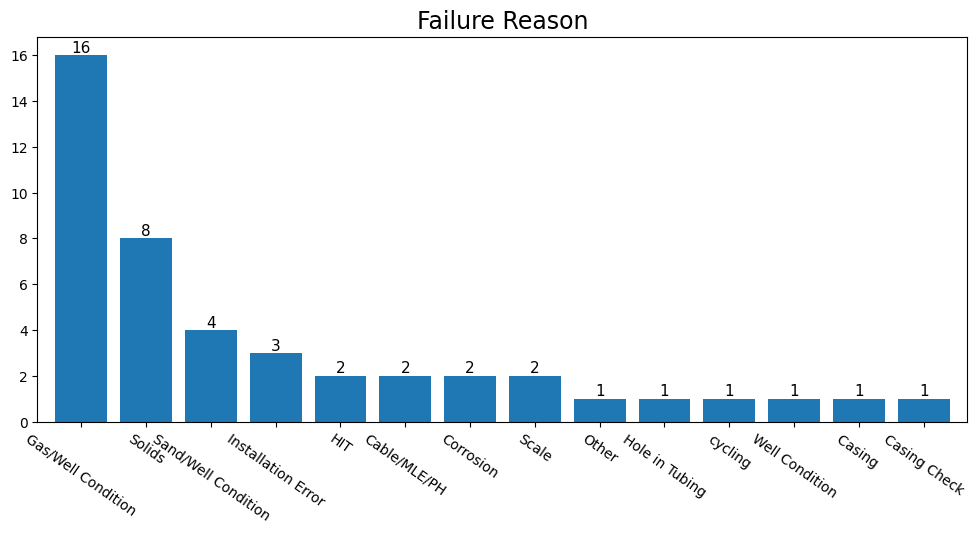

In [145]:
fail_reasons = esp_df.Fail_reason.value_counts().to_frame()
fig,ax = plt.subplots(figsize=(12,5))
fs=14
p = ax.bar(fail_reasons.index,fail_reasons["count"])
ax.margins(x=0.02)
ax.bar_label(p, label_type='edge', fontsize=fs-3)
for tick in ax.get_xticklabels():
    tick.set_rotation(-35)

ax.set_title("Failure Reason", fontsize=fs+3)
plt.savefig("images/tracker_failures.png", dpi=200, facecolor="w", edgecolor="none",bbox_inches="tight")
plt.show()